In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
torch.__version__

'2.4.1+cu118'

In [3]:
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

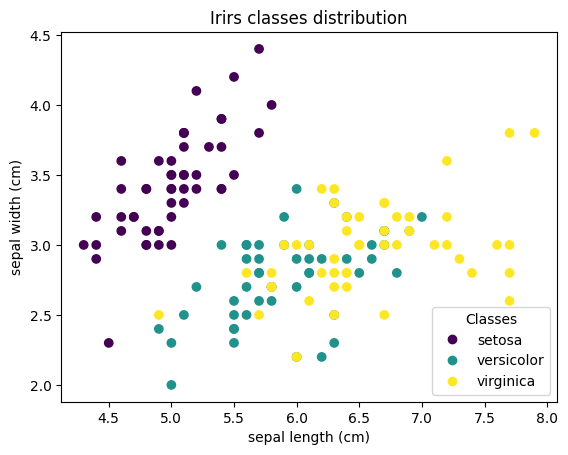

In [4]:
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
plt.title('Irirs classes distribution')
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [5]:
# get and split aour data
# remove class 2
X = iris.data[iris.target != 2]
y = iris.target[iris.target != 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
X.shape, y.shape

((100, 4), (100,))

In [7]:
# check docs
print(torch.nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in training or
         

In [8]:
# building torch model
# create a network that stacks layers on top of each other
model = torch.nn.Sequential()

# add first "dense" layer with 4 input units and 1 output unit.
model.add_module("l1", torch.nn.Linear(4, 1))

# as we deal with multiclass - add Softmax layer
model.add_module("l2", torch.nn.Sigmoid())

# add optimizer
opt = torch.optim.SGD(model.parameters(), lr=0.001)

In [9]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 4]), torch.Size([1])]


In [10]:
# learning our model
history = []

for i in range(1000):
    # sampling 50 random objects
    ix = np.random.randint(0, len(X_train), 50)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    # predict probabilities
    y_predicted = model(x_batch)[:, 0]

    # compute loss
    # cross_entropy - loss on one object, mean allows do it for all samples
    loss = torch.mean(
        torch.nn.functional.binary_cross_entropy(y_predicted, y_batch, reduction='none'),
        dim=0, keepdims=True
    )

    # compute gradient
    loss.backward()

    # do optimizer step
    opt.step()

    # clear grads
    opt.zero_grad()

    # collect history
    history.append(loss.data.numpy())
    
    if i % 100 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.537
step #100 | mean loss = 0.488
step #200 | mean loss = 0.446
step #300 | mean loss = 0.434
step #400 | mean loss = 0.419
step #500 | mean loss = 0.397
step #600 | mean loss = 0.374
step #700 | mean loss = 0.366
step #800 | mean loss = 0.347
step #900 | mean loss = 0.327


In [11]:
# use our model to predict classes
pred_test = model(torch.tensor(X_test, dtype=torch.float32))
pred_test = np.array(pred_test > 0.5)

In [12]:
print(accuracy_score(y_test, pred_test))

1.0
